# Выбор локации для скважины

**ОПИСАНИЕ ПРОЕКТА**

**Цель бизнеса**. Добывающей компании «ГлавРосГосНефть» требуется решить бизнес-задачу: необходимо определить, где бурить новую скважину, так, чтобы добыча принесла наибольшую прибыль. 

**Цели проекта**: 
1. Построить модель машинного обучения, которая поможет определить такой регион.
2. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Входные данные**. Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Характеристики для каждой скважины в регионе уже известны. 

Данные геологоразведки трёх регионов находятся в файлах: 
- `/datasets/geo_data_0.csv`
- `/datasets/geo_data_1.csv`
- `/datasets/geo_data_2.csv`

Также известны шаги для выбора локации:
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Обязательные условия от заказчика:**
1. Использовать модель линейной регрессии (остальные — недостаточно предсказуемые).
2. Исследовать 500 точек при геологоразведке, выбрать 200 с наибольшими запасами для расчёта прибыли.
3. Бюджет на разработку скважин в регионе — 10 млрд рублей.
4. Стоимость одного барреля нефти 450 рублей. Объём указан в 1000 баррелей.
5. Выбрать регионы, в которых вероятность убытков меньше 2.5%. Среди регионов, прошедших оценку рисков, выбрать один с наибольшей средней прибылью.

**Ход исследования:**
1. Загрузка и подготовка данных.
2. Обучение и проверка модели.
3. Подготовка к расчёту прибыли.
4. Расчёт прибыли и рисков.
5. Общий вывод.

## Загрузка и подготовка данных

### Импорт библиотек

Импортируем нужные библиотеки, фиксируем константы.

In [1]:
!pip install phik -q

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from phik import phik_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sns.set_theme()

In [3]:
RANDOM_STATE = 12345
TEST_SIZE = 0.25
BUDGET = 10**10 
TOP_WELLS = 200
SELECTION_WELLS = 500
UNIT_INCOME = 450000

### Загрузка данных

Загружаем три предоставленных датасета, в каждом из которых информация об одном из трех регионов: пробы нефти в 10 000 месторождениях, где измерили качество нефти и объём её запасов.

**Пояснения к данным:**
- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` — три признака точек;
- `product` — объём запасов в скважине (тыс. баррелей).

In [4]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
display(data_0.head())
display(data_0.info())
display(data_0.describe())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


**Комментарий:** В загруженном датасете `datasets/geo_data_0.csv` мы видим следующее:

1. Корректное оформление.
2. Присутствуют все заявленные данные, их объем достаточен для анализа и обучения, типы данных указаны корректно.
3. Пропусков в датасете нет. 
4. В описательной статистике датасета на первый взгляд, вероятно, есть сильная изменчивость в данных или выбросы. Стандартное отклонение во всех трех признаков больше среднего/медианного значения по признаку. 

In [5]:
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
display(data_1.head())
display(data_1.info())
display(data_1.describe())

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


**Комментарий:** В загруженном датасете `datasets/geo_data_1.csv` мы видим следующее:

1. Корректное оформление.
2. Присутствуют все заявленные данные, их объем достаточен для анализа и обучения, типы данных указаны корректно.
3. Пропусков в датасете нет. 
4. В описательной статистике датасета на первый взгляд, вероятно, есть сильная изменчивость в данных или выбросы. Стандартное отклонение в признаках f0 и f1 больше среднего/медианного значения по признаку. 

In [6]:
data_2 = pd.read_csv('/datasets/geo_data_2.csv')
display(data_2.head())
display(data_2.info())
display(data_2.describe())

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Комментарий:** В загруженном датасете `datasets/geo_data_2.csv` мы видим следующее:

1. Корректное оформление.
2. Присутствуют все заявленные данные, их объем достаточен для анализа и обучения, типы данных указаны корректно.
3. Пропусков в датасете нет. 
4. В описательной статистике датасета на первый взгляд, вероятно, есть сильная изменчивость в данных или выбросы. Стандартное отклонение во всех трех признаков больше среднего/медианного значения по признаку. 

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> Все загруженные датасеты соответствуют заявленному описанию, данных достаточно для того, чтобы проводить анализ, типы данных указаны корректно и пропусков нет. Используется корректное оформление. Описательная статистика показывает, что во всех трёх датасетах могут быть выбросы/аномалии/высокая изменчивость данных. </div>

### Предобработка данных

Во всех трёх датасетах нет пропусков и указан корректный тип данных, поэтому проверять на данном этапе мы будем только дубликаты. В датасете могут быть только явные дубликаты, так как нет, кроме id, данных типа object.

In [7]:
#проверяем датасеты на наличие явных дубликатов
print('Явные дубликаты id в data_0:', data_0['id'].duplicated().sum())
print('Явные дубликаты id в data_1:', data_1['id'].duplicated().sum())
print('Явные дубликаты id в data_2:', data_2['id'].duplicated().sum())

Явные дубликаты id в data_0: 10
Явные дубликаты id в data_1: 4
Явные дубликаты id в data_2: 4


**Комментарий**: В датасетах встречаются повторения уникального идентификатора скважины, что точно ошибка, так как идентификатор, логично, должен быть уникальным. Такие строки в датасетах мы удаляем. 

In [8]:
data_0 = data_0.drop_duplicates(subset='id', keep=False)
data_1 = data_1.drop_duplicates(subset='id', keep=False)
data_2 = data_2.drop_duplicates(subset='id', keep=False)

display(data_0.shape)
display(data_1.shape)
display(data_2.shape)

(99980, 5)

(99992, 5)

(99992, 5)

In [9]:
#прячем id в индексы, чтобы иметь возможность проверить дубликаты без id
data_0.set_index('id', inplace=True)
data_1.set_index('id', inplace=True)
data_2.set_index('id', inplace=True)

In [10]:
#проверяем датасеты на наличие явных дубликатов
print('Явные дубликаты в data_0:', data_0.duplicated().sum())
print('Явные дубликаты в data_1:', data_1.duplicated().sum())
print('Явные дубликаты в data_2:', data_2.duplicated().sum())

Явные дубликаты в data_0: 0
Явные дубликаты в data_1: 0
Явные дубликаты в data_2: 0


<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 
    В датасетах встречаются повторения уникального идентификатора скважины, что точно ошибка, так как идентификатор должен быть уникальным. Такие дубликаты были удалены. Итоговые размеры датасетов после удаления дубликатов:
    
    1. data_0: (99980, 5)
    
    2. data_1: (99992, 5)
    
    3. data_2: (99992, 5) 
</div>

### Исследовательский анализ данных

#### Регион №1

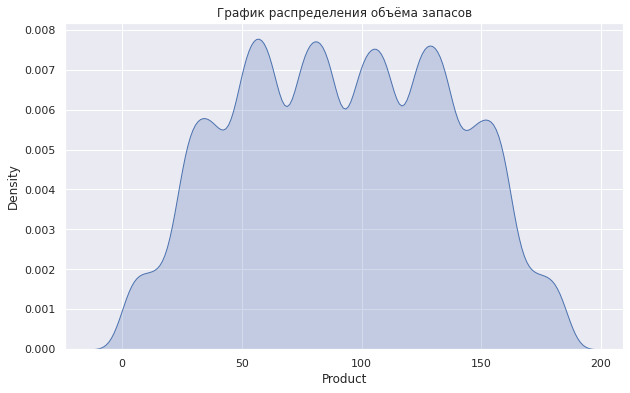

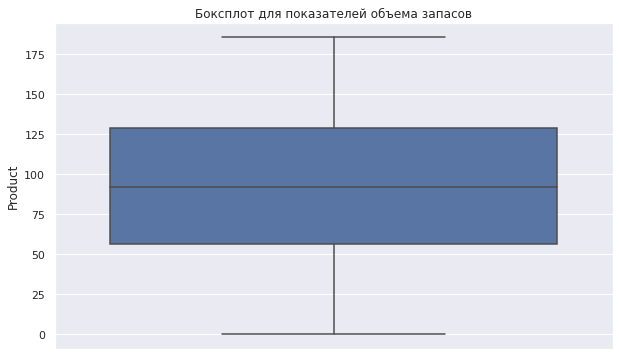

Описательная статистика:


count    99980.000000
mean        92.499166
std         44.289044
min          0.000000
25%         56.496513
50%         91.847928
75%        128.564089
max        185.364347
Name: product, dtype: float64

In [11]:
#создаем функцию, чтобы оценить распределение целевого признака, объема запасов
def analyze_product(df):
    #построение графика распределения
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df['product'], fill=True)
    plt.title("График распределения объёма запасов")
    plt.xlabel('Product')
    plt.show()
    
    #построение боксплота
    plt.figure(figsize=(10, 6))
    sns.boxplot(y='product', data=df)
    plt.title("Боксплот для показателей объема запасов")
    plt.ylabel('Product')
    plt.show()
    
    #описательная статистика
    print("Описательная статистика:")
    display(df['product'].describe())

analyze_product(data_0)

**Комментарий**: Визуально выбросов нет, что данные сравнительно стабильно распределены, можно только заметить, что есть повторяющиеся группы значений.

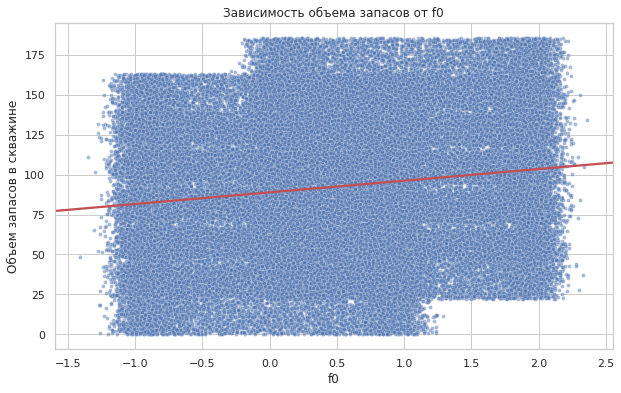

In [12]:
#создаем функцию, чтобы посмотреть распределение признаков и зависимость от них объёма запасов 
def plot_feature_vs_product(data, column):
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(
        x=column, 
        y='product', 
        data=data, 
        alpha=0.5, 
        s=15,  
        color='b'
    )
    
    sns.regplot(
        x=column, 
        y='product', 
        data=data, 
        scatter=False, 
        ci=None, 
        color='r', 
        truncate=False
    )
    
    plt.title(f"Зависимость объема запасов от {column}")
    plt.xlabel(column)
    plt.ylabel("Объем запасов в скважине")
    plt.show()

plot_feature_vs_product(data_0, 'f0')

**Комментарий**: Корреляция между признаком f0 и объемом запасов очень низкая.

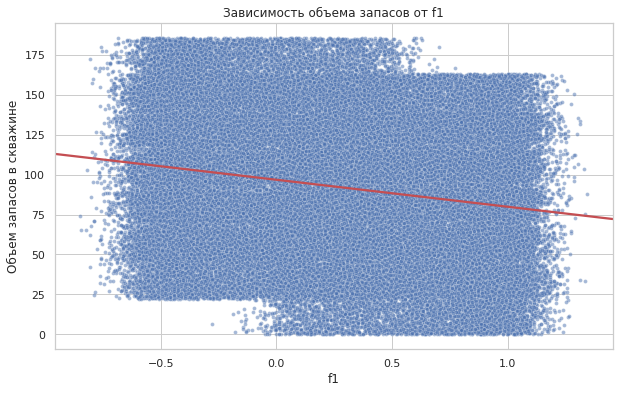

In [13]:
plot_feature_vs_product(data_0, 'f1')

**Комментарий**: Корреляция между признаком f1 и объемом запасов довольно низкая.

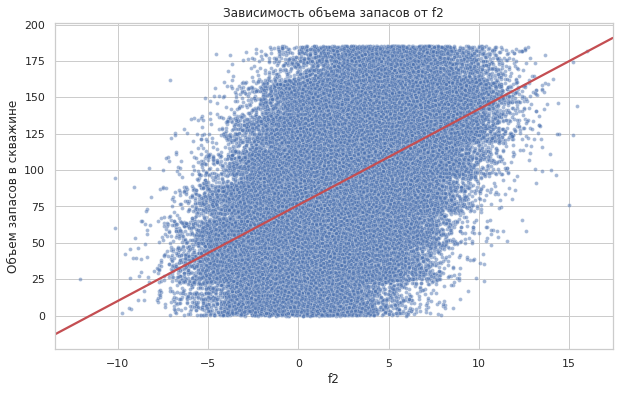

In [14]:
plot_feature_vs_product(data_0, 'f2')

**Комментарий**: В данном случае мы видим прямую зависимость между признаком f3 и объемом запасов. 

#### Регион №2

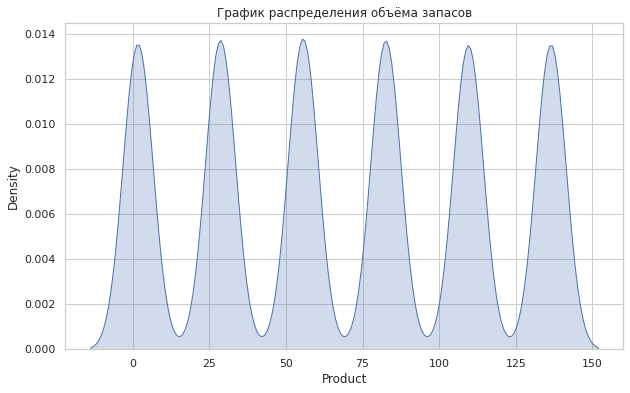

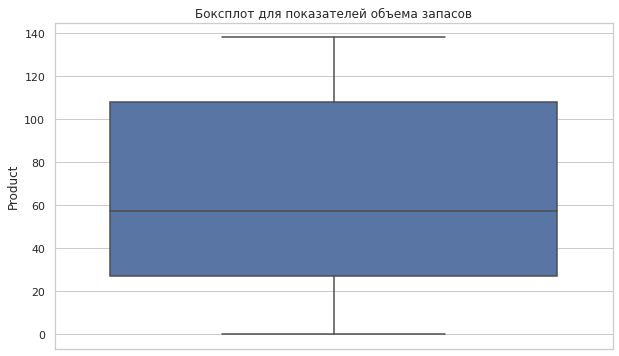

Описательная статистика:


count    99992.000000
mean        68.824148
std         45.944889
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64

In [15]:
analyze_product(data_1)

**Комментарий**: Судя по графику распределения, в датасете повторяются фиксированные значения объема запасов. Стандартное отклонение высокое, но очевидных выбросов нет, так что считаем, что для этого признака данные стабильны, пусть и с широким диапазоном.

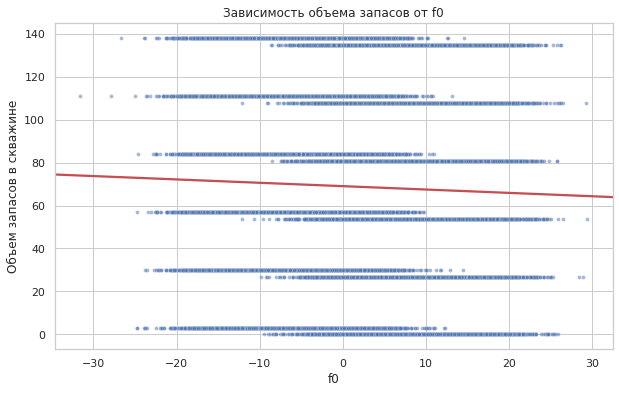

In [16]:
plot_feature_vs_product(data_1, 'f0')

**Комментарий**: Объем запасов принимает дискретные значения, что возможно указывает на округление данных или специфическую шкалу измерения, а сильно рассеяние точек по оси f0 говорит о том, что в данных, вероятно, есть шум (выбросы или аномалии) или просто большой разброс данных, что мы увидели при выгрузке датасета в описательной статистике. Так как мы не знаем, что конкретно подразумевает собой данный признак, мы оставляем его в таком же виде, данные не обрабатываем. 

Также по графику видим слабую корреляцию между признаком f0 и объемом запасов. 

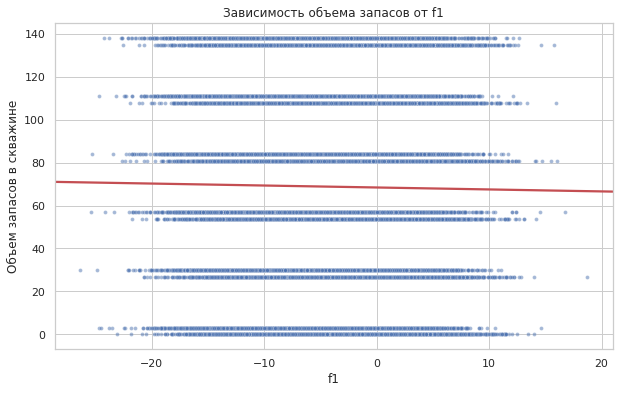

In [17]:
plot_feature_vs_product(data_1, 'f1')

**Комментарий**: В данном случае аналогично, только корреляции практически и вовсе нет. 

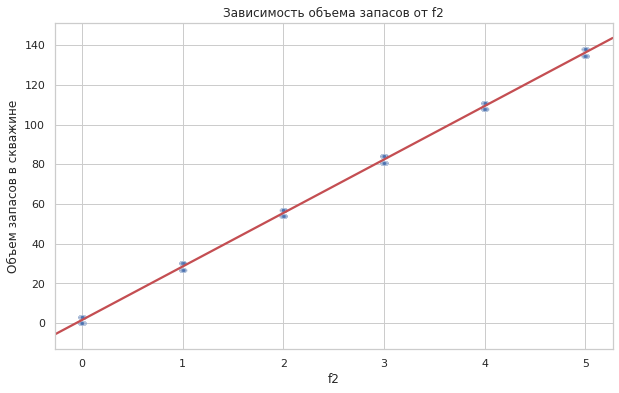

In [18]:
plot_feature_vs_product(data_1, 'f2')

**Комментарий**: Точки со значениями признака расположены вдоль прямой линии, что указывает на почти идеальную линейную связь между f2 и объемом запасов.

#### Регион №3

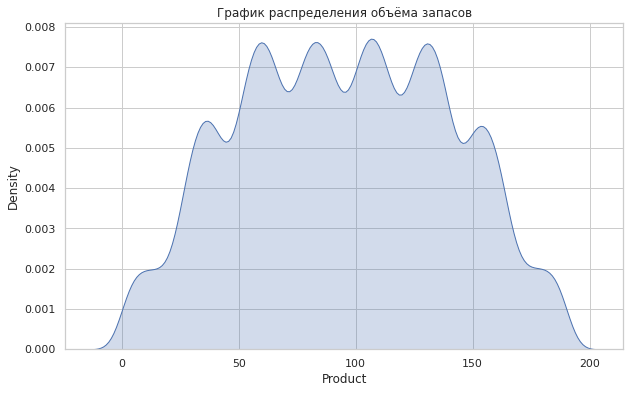

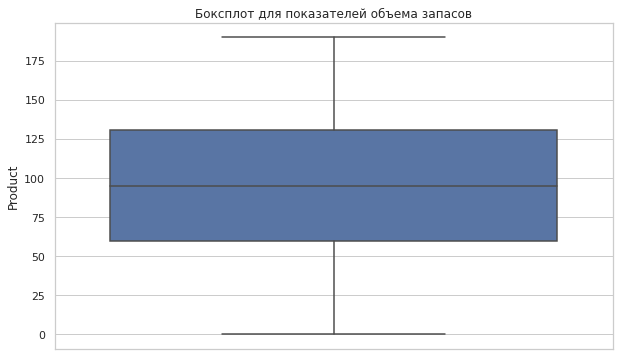

Описательная статистика:


count    99992.000000
mean        94.998767
std         44.747763
min          0.000000
25%         59.450441
50%         94.925026
75%        130.585544
max        190.029838
Name: product, dtype: float64

In [19]:
analyze_product(data_2)

**Комментарий**:  Визуально выбросов нет, что данные сравнительно стабильно распределены, можно только заметить, что есть повторяющиеся группы значений, распределение похоже на нормальное.

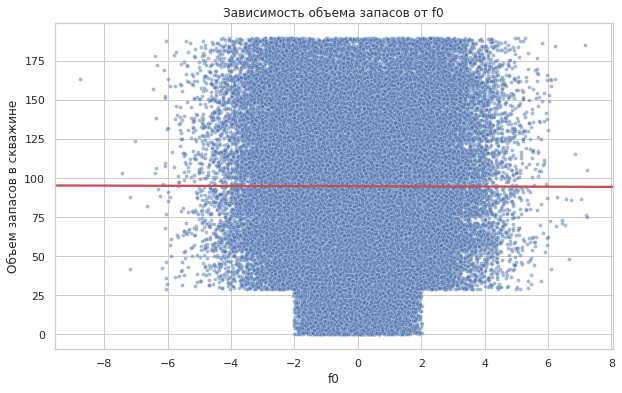

In [20]:
plot_feature_vs_product(data_2, 'f0')

**Комментарий**: Плоская линия регрессии (почти горизонтальная) указывает на слабую или отсутствующую линейную зависимость между f0 и объемом запасов. 

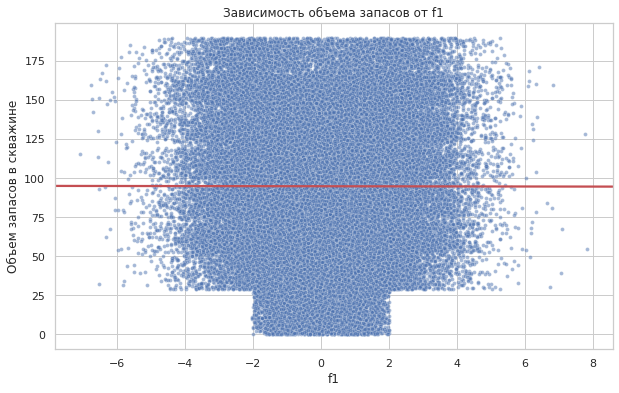

In [21]:
plot_feature_vs_product(data_2, 'f1')

**Комментарий**: аналогично и с признаком f1.

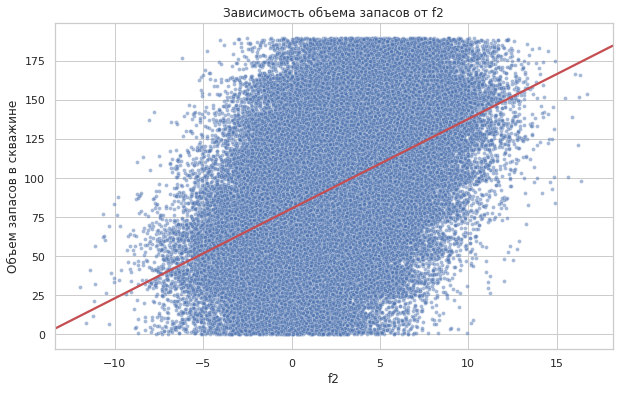

In [22]:
plot_feature_vs_product(data_2, 'f2')

**Комментарий**: В данном случае мы видим прямую зависимость между признаком f3 и объемом запасов. 

#### Исследовательский анализ данных: выводы

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;">
    
В данных по трем регионам можно заметить повторяющиеся тенденции:
    

    1) В признаке product очевидных выбросов нет, данные сравнительно стабильно распределены, можно только заметить, что есть повторяющиеся группы значений. Особенно выделяется регион №2, где явно значения объема запасов фиксированы/распределены по группам. 

    2) В значениях признаков f1 и f2 можно заметить очень большой разброс данных (влияют либо аномалии, либо выбросы), но обработать такие данные не можем из-за непонимания, что представляют из себя признаки. 
    
    3) Во всех трёх регионах либо слабая корреляция между product и признаками f1 и f2, либо она вовсе отсутствует. 
    
    4) Во всех трёх регионах наблюдается прямая зависимость объема запасов от признака f3. 
    
</div>

### Корреляционный анализ данных

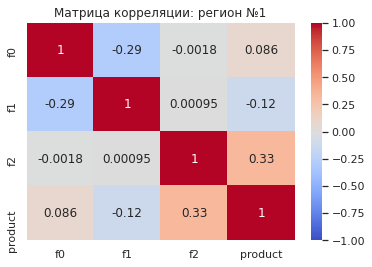

In [23]:
sns.heatmap(data_0.corr(method='kendall'), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции: регион №1')
plt.show()

**Комментарий**: В данном случае мы видим слабую корреляцию между признаками. 

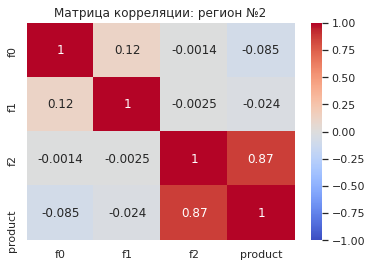

In [24]:
sns.heatmap(data_1.corr(method='kendall'), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции: регион №2')
plt.show()

**Комментарий**: В данном случае мы слабую корреляцию между признаками f0, f1 и product, но очень сильную между f2 и product (модель может переобучиться). Низкая корреляция между f0, f1 и product означает, что эти признаки плохо влияют на предсказательную способность модели. Их использование может сказаться на точности модели, на её обучении, это стоит иметь в виду.

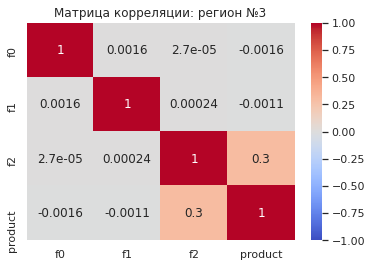

In [25]:
sns.heatmap(data_2.corr(method='kendall'), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции: регион №3')
plt.show()

**Комментарий**: В данном случае мы видим практически отсутствие корреляции между признаками, исключение составляет только слабая корреляция между f3 и product.

### Подготовка данных

На данном этапе разделим признаки на входные и целевые и отмасштабируем входные для более точного обучения моделей. 

In [26]:
#разделим признаки на входные и целевой в каждом из регионов
features = ['f0', 'f1', 'f2']
target = ['product']
X_0 = data_0[features]
y_0 = data_0[target]
X_1 = data_1[features]
y_1 = data_1[target]
X_2 = data_2[features]
y_2 = data_2[target]

In [27]:
#масштабируем данные
scaler = StandardScaler()

X_0_scaled = scaler.fit_transform(X_0)
X_1_scaled = scaler.fit_transform(X_1)
X_2_scaled = scaler.fit_transform(X_2)

### Загрузка и подготовка данных: выводы

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 

**Загрузка и предобработка данных**

Все загруженные датасеты соответствуют заявленному описанию, данных достаточно для того, чтобы проводить анализ, типы данных указаны корректно и пропусков нет. Используется корректное оформление. Описательная статистика показывает, что во всех трёх датасетах могут быть выбросы/аномалии/высокая изменчивость данных.
    
В датасетах встречаются повторения уникального идентификатора скважины, что точно ошибка, так как идентификатор должен быть уникальным. Такие дубликаты были удалены. Итоговые размеры датасетов после удаления дубликатов: data_0: (99980, 5), data_1: (99992, 5), data_2: (99992, 5).
   
**Исследовательский анализ данных** 
    
В данных по трем регионам можно заметить повторяющиеся тенденции:

    1) В признаке product очевидных выбросов нет, данные сравнительно стабильно распределены, можно только заметить, что есть повторяющиеся группы значений. Особенно выделяется регион №2, где явно значения объема запасов фиксированы/распределены по группам. 

    2) В значениях признаков f1 и f2 можно заметить очень большой разброс данных (влияют либо аномалии, либо выбросы), но обработать такие данные не можем из-за непонимания, что представляют из себя признаки. 
    
    3) Во всех трёх регионах либо слабая корреляция между product и признаками f1 и f2, либо она вовсе отсутствует. 
    
    4) Во всех трёх регионах наблюдается прямая зависимость объема запасов от признака f3. 
    
**Корреляционный анализ данных**
    
Во всех трех регионах обнаружена слабая корреляция признаков f0, f1 и product, либо она вовсе отсутствовала. Во всех трех регионах есть корреляция между признаком f3 и product, в регионе №2 она особенно сильная - 0.87.
    
**Подготовка данных**
    
Все три датасета были разделены на входные и целевой признаки, входные были отмасштабированы для более точного обучения моделей.
</div>

## Обучение и проверка модели

В данном шаге мы обучим и проверим модель для каждого региона. Для этого напишем функцию, с помощью которой обучим каждую из моделей. Функция будет разделять исходные данные на обучающую и валидационную выборки (75/25), обучать модель линейной регрессии (выбираем сразу её, так как остальные заказчику не подойдут), делать предсказания на валидационной выборке, считать и фиксировать средний запас предсказанного сырья и RMSE модели. Метрика RMSE подойдет в нашем случае, так как есть разброс данных и она удобна для сравнения моделей.

In [28]:
def model_fit(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    print('Train shape:', X_train.shape)
    print('Valid shape:', X_valid.shape)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    predict = model.predict(X_valid)

    predict_mean = predict.mean().item() 
    rmse = np.sqrt(np.mean((predict - y_valid) ** 2)).item()

    print('Cредний запас предсказанного сырья: {:.4f}'.format(predict_mean))
    print('RMSE модели: {:.4f}'.format(rmse))
    
    return y_valid, predict

### Регион №1

In [29]:
y_0_valid, predict_0 = model_fit(X_0_scaled, y_0)

Train shape: (74985, 3)
Valid shape: (24995, 3)
Cредний запас предсказанного сырья: 92.4238
RMSE модели: 37.7169


**Комментарий**: RMSE достаточно высок (37.8), такой высокий показатель, вероятно, связан с очень низкой корреляцией между входными и целевым признаками. Средний показатель запаса предсказанного сырья составляет 92.4.

### Регион №2 

In [30]:
y_1_valid, predict_1 = model_fit(X_1_scaled, y_1)

Train shape: (74994, 3)
Valid shape: (24998, 3)
Cредний запас предсказанного сырья: 68.9831
RMSE модели: 0.8915


**Комментарий**: RMSE достаточно мал (0.9), такой низкий показатель, вероятно, связан как раз с высокой корреляцией между признаком f3 и product, модель достаточно точна. Средний показатель запаса предсказанного сырья составляет 68.9 (ниже остальных регионов). Данные для этого региона, вероятно, моделировать проще.

### Регион №3

In [31]:
y_2_valid, predict_2 = model_fit(X_2_scaled, y_2)

Train shape: (74994, 3)
Valid shape: (24998, 3)
Cредний запас предсказанного сырья: 95.1162
RMSE модели: 39.9755


**Комментарий**: RMSE самый высокий среди регионов (40), такой высокий показатель, вероятно, связан с очень низкой корреляцией между входными и целевым признаками. Средний показатель запаса предсказанного сырья составляет 95.1.

### Обучение и проверка моделей: выводы

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 

**Среднее предсказанное значение сырья**:
  - Регион №2 имеет заметно более низкий средний запас по сравнению с другими, что может указывать на меньший потенциал запасов этого региона.
  - Регион №1 и Регион №3 имеют схожие средние значения, потенциал запасов сырья схож.

**RMSE моделей**:
  - RMSE для региона №2 значительно ниже, что указывает на более точные предсказания в этом регионе. Это может означать, что данные для региона №2 проще моделировать.
  - RMSE для региона №1 и региона №3 существенно выше, что может указать на наличие большего разброса в данных или сложность их моделирования. По сути модели не рабочие, если ориентироваться на разброс данных в описательных статитистиках.

</div>

## Подготовка к расчёту прибыли

### Подготовка

На данном этапе мы рассчитаем достаточный объём сырья для безубыточной разработки новой скважины, а также сравним полученный объём сырья со средним запасом в каждом регионе. Для расчетов сохраним в отдельные переменные все ключевые значения, которые дал нам бизнес:

- BUDGET = 10**10 (бюджет на разработку скважин в регионе - 10 млрд рублей);
- TOP_WELLS = 200 (200 лучших скважин из выборки);
- SELECTION_WELLS = 500 (выборка из 500 скважин);
- UNIT_INCOME = 450000 (доход с каждой единицы продукта - 450 тыс. рублей (так как стоимость одного барреля нефти 450 рублей, а объём в наших датасетах указан в 1000 баррелей)).

Указанные контстанты зафиксированы в начале проекта. 

Будут исследовать случайные 500 точек при геологоразведке, из них выбраны выбрать 200 с наибольшими запасами для расчёта прибыли.

In [32]:
min_product = BUDGET / (TOP_WELLS * UNIT_INCOME)
print('Достаточный объём сырья для безубыточной разработки новой скважины: {:.2f}'.format(min_product))

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11


In [33]:
#выводим средние значения по показателю объема сырья по изначальным данным
print('Средний показатель объема сырья для одной скважины в регионе №1: {:.2f}'.format(data_0['product'].mean()))
print('Средний показатель объема сырья для одной скважины в регионе №2: {:.2f}'.format(data_1['product'].mean()))
print('Средний показатель объема сырья для одной скважины в регионе №3: {:.2f}'.format(data_2['product'].mean()))

Средний показатель объема сырья для одной скважины в регионе №1: 92.50
Средний показатель объема сырья для одной скважины в регионе №2: 68.82
Средний показатель объема сырья для одной скважины в регионе №3: 95.00


### Подготовка к расчёту прибыли: вывод

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 
    
Был рассчитан достаточный объём сырья для безубыточной разработки новой скважины - 111.11. На данным этапе ни один регион по средним показателям не подходит для безубыточной разработки: 

- Регион №1: средний показатель запаса предсказанного сырья составляет 92.3, реального - 92.5
- Регион №2: средний показатель запаса предсказанного сырья составляет 68.7, реального - 68.8
- Регион №3: средний показатель запаса предсказанного сырья в составляет 94.8, реального - 95.

</div>

## Расчёт прибыли и рисков 

На этом этапе нам будет необходимо выбрать регионы, в которых вероятность убытков меньше 2.5%. Среди регионов, прошедших оценку рисков, выбрать один с наибольшей средней прибылью. 

### Расчёт прибыли 

Для расчёта прибыли, мы напишем функцию по выбранным скважинам и предсказаниям модели. Фунция будет:
1. Выбирать 200 скважин с максимальными значениями предсказаний.
2. Суммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
3. Рассчитывать прибыль для полученного объёма сырья.

In [34]:
#преобразуему в нужный формат предсказания и целевые значения
y_0_valid = pd.Series(y_0_valid['product']).reset_index(drop=True)
y_1_valid = pd.Series(y_1_valid['product']).reset_index(drop=True)
y_2_valid = pd.Series(y_2_valid['product']).reset_index(drop=True)

predict_0 = pd.Series(*predict_0.reshape(1,-1))
predict_1 = pd.Series(*predict_1.reshape(1,-1))
predict_2 = pd.Series(*predict_2.reshape(1,-1))

In [35]:
#создаем функцию, которая считает среднюю прибыль для полученного в регионе объема сырья
def calculate_profit(predict, y_valid):
    
    #выбираем 200 лучших по объему
    top_preds = predict.sort_values(ascending=False)[:TOP_WELLS]
    
    #считаем суммарный целевой объем
    top_targets = y_valid[top_preds.index]
    volume = sum(top_targets)
    
    #считаем прибыль 
    profit = volume * UNIT_INCOME - BUDGET
    return volume, profit

In [36]:
volume_0, profit_0 = calculate_profit(predict_0, y_0_valid)
print('Суммарный целевой объём сырья в регионе №1: {:.2f}'.format(volume_0))
print('Прибыль для полученного объёма сырья в регионе №1 (руб): {:.2f}'.format(profit_0))

Суммарный целевой объём сырья в регионе №1: 29191.17
Прибыль для полученного объёма сырья в регионе №1 (руб): 3136026056.66


In [37]:
volume_1, profit_1 = calculate_profit(predict_1, y_1_valid)
print('Суммарный целевой объём сырья в регионе №2: {:.2f}'.format(volume_1))
print('Прибыль для полученного объёма сырья в регионе №2 (руб): {:.2f}'.format(profit_1))

Суммарный целевой объём сырья в регионе №2: 27589.08
Прибыль для полученного объёма сырья в регионе №2 (руб): 2415086696.68


In [38]:
volume_2, profit_2 = calculate_profit(predict_2, y_2_valid)
print('Суммарный целевой объём сырья в регионе №3: {:.2f}'.format(volume_2))
print('Прибыль для полученного объёма сырья в регионе №3 (руб): {:.2f}'.format(profit_2))

Суммарный целевой объём сырья в регионе №3: 27702.10
Прибыль для полученного объёма сырья в регионе №3 (руб): 2465945792.01


<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 
    
После расчёта прибыли мы видим, что все регионы являются прибыльными.

</div>

### Расчёт рисков

На данном этапе посчитаем риски и прибыль для каждого региона. Для этого мы применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Также найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль. На основе полученных данных предложим регион для разработки скважин и обоснуйте выбор.

In [48]:
#функция для расчета средней прибыли, доверительного интервала и риска убытков
def risk_calc(y_valid, predicts):

    bootstrap_samples = 1000 
    alpha = 0.05
    
    #расчитываем среднюю прибыль
    profits = []
    for _ in range(bootstrap_samples):
         #выбираем 500 случайных скважин в регионе
        random_sample = predicts.sample(n=SELECTION_WELLS, replace=True)
        _, profit = calculate_profit(random_sample, y_valid)
        profits.append(profit)
    profits = pd.Series(profits)
    profit_mean = profits.mean()
    
    #задаем границы интервала
    conf_int_left = profits.quantile(alpha/2)
    conf_int_right = profits.quantile(1 - alpha/2)
    
    #считаем, сколько раз прибыль была отрицательной (то есть сколько раз был убыток)
    loss_count = 0
    for inc in profits:
        if inc < 0 :
            loss_count += 1
            
    #выводим процент случаев убытков из всех итераций бутстрепа      
    loss_rate = loss_count / bootstrap_samples
    
    return profit_mean, conf_int_left, conf_int_right, loss_rate

In [49]:
profit_mean_0, conf_int_left_0, conf_int_right_0, loss_rate_0 = risk_calc(y_0_valid, predict_0)
print('Средняя прибыль для региона №1 {:.2f} (млн. Р)'.format(profit_mean_0 / 10**6))
print('95% доверительный интервал для региона №1: {:.2f} : {:.2f} (млн. Р)'.format(
    conf_int_left_0 / 10**6, conf_int_right_0 / 10**6)
     )
print('Риск убытков: {:.2f} %'.format(loss_rate_0 * 100))

Средняя прибыль для региона №1 445.61 (млн. Р)
95% доверительный интервал для региона №1: -69.79 : 944.39 (млн. Р)
Риск убытков: 4.60 %


In [50]:
profit_mean_1, conf_int_left_1, conf_int_right_1, loss_rate_1 = risk_calc(y_1_valid, predict_1)
print('Средняя прибыль для региона №1 {:.2f} (млн. Р)'.format(profit_mean_1 / 10**6))
print('95% доверительный интервал для региона №1: {:.2f} : {:.2f} (млн. Р)'.format(
    conf_int_left_1 / 10**6, conf_int_right_1 / 10**6)
     )
print('Риск убытков: {:.2f} %'.format(loss_rate_1 * 100))

Средняя прибыль для региона №1 480.41 (млн. Р)
95% доверительный интервал для региона №1: 98.89 : 877.25 (млн. Р)
Риск убытков: 0.40 %


In [51]:
profit_mean_2, conf_int_left_2, conf_int_right_2, loss_rate_2 = risk_calc(y_2_valid, predict_2)
print('Средняя прибыль для региона №1 {:.2f} (млн. Р)'.format(profit_mean_2 / 10**6))
print('95% доверительный интервал для региона №1: {:.2f} : {:.2f} (млн. Р)'.format(
    conf_int_left_2 / 10**6, conf_int_right_2 / 10**6)
     )
print('Риск убытков: {:.2f} %'.format(loss_rate_2 * 100))

Средняя прибыль для региона №1 325.79 (млн. Р)
95% доверительный интервал для региона №1: -231.55 : 832.28 (млн. Р)
Риск убытков: 11.30 %


### Расчёт прибыли и рисков: выводы

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 
    
Средняя прибыль для каждого из трёх регионов положительная (то есть без убытка):
- Регион №1: 439.61 млн рублей
- Регион №2: 477.34 млн рублей
- Регион №3: 320.11 млн рублей
    
У региона №1 и региона №3 есть вероятность отрицательной прибыли и эта вероятность выше, чем у региона №2, и выше, чем разрешил заказчик (2.5%): более 4% и более 10% соответственно. По такому критерию проходит только регион №2, риск убытков в этом регионе - менее 2%. У него же и самая высокая средняя прибыль из всех трёх регионов. 
    
**Итог**: для разработки подходит регион №2: регион прибыльный и риск убытков меньше допустимого.  

</div>

## Общий вывод

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

**ЦЕЛЬ ПРОЕКТА**

Добывающей компании «ГлавРосГосНефть» требуется решить бизнес-задачу: необходимо определить, где бурить новую скважину, так, чтобы добыча принесла наибольшую прибыль. 

Перед нами стояло **две задачи**: 
1. Построить модель машинного обучения, которая поможет определить такой регион.
2. Проанализировать возможную прибыль и риски техникой *Bootstrap.*
    
</div>

<div style="border: 1px solid black; padding: 10px; border-radius: 5px;"> 

**ХОД РАБОТЫ**

**1. Загрузка и предобработка данных**. 
    
    Мы загрузили, проверили и предобработали данные: были удалены дубликаты среди id, так как они должны быть уникальны.
    
**2. Анализ данных**. 
    
    Мы провели исследовательский и корреляционный анализы данных. Исходя из полученных данных, мы выяснили, что в данных по трем регионам можно заметить повторяющиеся тенденции:
    - В признаке product очевидных выбросов нет, данные сравнительно стабильно распределены, можно только заметить, что есть повторяющиеся группы значений. Особенно выделяется регион №2, где явно значения объема запасов фиксированы/распределены по группам.
    - В значениях признаков f1 и f2 можно заметить очень большой разброс данных (влияют либо аномалии, либо выбросы), но обработать такие данные не можем из-за непонимания, что представляют из себя признаки.
    - Во всех трёх регионах либо слабая корреляция между product и признаками f1 и f2, либо она вовсе отсутствует.
    - Во всех трёх регионах наблюдается прямая зависимость объема запасов от признака f3. 
    - При корреляционном анализе данных во всех трех регионах обнаружена слабая корреляция признаков f0, f1 и product, либо она вовсе отсутствовала. Во всех трех регионах есть корреляция между признаком f3 и product, в регионе №2 она особенно сильная - 0.87.
    
**3. Обучение и оценка моделей**. 
    
    Подготовили данные и обучили три модели LinearRegression(), по одной для каждого из трех регионов. Мы оценили модели метрикой RMSE: RMSE для региона №2 значительно ниже, что указывает на более точные предсказания в этом регионе. Это может означать, что данные для региона №2 проще моделировать. RMSE для региона №1 и региона №3 существенно выше, что может указать на наличие большего разброса в данных или сложность их моделирования. По сути модели не рабочие, если ориентироваться на разброс данных в описательных статитистиках.
    
**4. Расчет прибыли и рисков**. 
    
    Был рассчитан достаточный объём сырья для безубыточной разработки новой скважины - 111.11. Для расчёта прибыли, мы написали функцию по выбранным скважинам и предсказаниям модели. С помощью неё мы отобрали 200 скважин с максимальными значениями предсказаний из случайно выборки в 500 скважин в регионе, суммировали целевое значение объёма сырья, соответствующее этим предсказаниям, и рассчитали прибыль для полученного объёма сырья.
    
    Мы применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли, нашли 95%-й доверительный интервал и риск убытков для каждого региона.
    
</div>

<div style="border: 3px solid black; padding: 10px; border-radius: 5px;"> 

**ИТОГОВЫЕ РЕКОМЕНДАЦИИ ДЛЯ БИЗНЕСА**

Использовать для добычи регион №2, так как:

- Наибольшая средняя прибыль по месторождениям с самым высоким объемом запасов (с наибольшой вероятностью) -  около 480 млн рублей. Для сравнения регион №1 - около 440 млн рублей, регион №3 - около 325 млн рублей.

- Единственный регион, где риск убытков меньше допустимого (2.5%) - менее 2% (в зависимости от выборки). Для сравнения риск убытков в регионе №1 - более 4%, в регионе №3 - более 10%.

- RMSE для региона №2 значительно ниже, что указывает на более точные предсказания в этом регионе. Данные для региона №2 проще моделировать, так как выше корреляция с входными признаками (с f3). 
    
</div>